# original dataset link provided below

In [1]:
%%html
<table cellspacing='2'>
<tr>
<td> <a href="https://shapenet.cs.stanford.edu/media/modelnet40_ply_hdf5_2048.zip">click to download modelnet40 classification dataset</a> <p>&nbsp;</p></td>
</tr>
<tr>
<td> <a href="https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_v0.zip">click to download modelnet40 segmentation dataset</a> <p>&nbsp;</p></td>
</tr>
</table>

click to download modelnet40 classification dataset
click to download modelnet40 segmentation dataset


# reconstruct the model for compiling

In [3]:
import numpy as np
import os
import tensorflow as tf
from keras import optimizers
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense, Flatten, Reshape, Dropout
from keras.layers import Convolution1D, MaxPooling1D, BatchNormalization
from keras.layers import Lambda
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import h5py


def mat_mul(A, B):
    return tf.matmul(A, B)


def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    label = f['label'][:]
    return (data, label)


In [4]:
# number of points in each sample
num_points = 2048

# number of categories
k = 40

# define optimizer
adam = optimizers.Adam(lr=0.001, decay=0.7)

# ------------------------------------ Pointnet Architecture
# input_Transformation_net
input_points = Input(shape=(num_points, 3))
x = Convolution1D(64, 1, activation='relu',
                  input_shape=(num_points, 3))(input_points)
x = BatchNormalization()(x)
x = Convolution1D(128, 1, activation='relu')(x)
x = BatchNormalization()(x)
x = Convolution1D(1024, 1, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=num_points)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(9, weights=[np.zeros([256, 9]), np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32)])(x)
input_T = Reshape((3, 3))(x)

# forward net
g = Lambda(mat_mul, arguments={'B': input_T})(input_points)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
g = BatchNormalization()(g)

# feature transform net
f = Convolution1D(64, 1, activation='relu')(g)
f = BatchNormalization()(f)
f = Convolution1D(128, 1, activation='relu')(f)
f = BatchNormalization()(f)
f = Convolution1D(1024, 1, activation='relu')(f)
f = BatchNormalization()(f)
f = MaxPooling1D(pool_size=num_points)(f)
f = Dense(512, activation='relu')(f)
f = BatchNormalization()(f)
f = Dense(256, activation='relu')(f)
f = BatchNormalization()(f)
f = Dense(64 * 64, weights=[np.zeros([256, 64 * 64]), np.eye(64).flatten().astype(np.float32)])(f)
feature_T = Reshape((64, 64))(f)

# forward net
g = Lambda(mat_mul, arguments={'B': feature_T})(g)
g = Convolution1D(64, 1, activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(128, 1, activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(1024, 1, activation='relu')(g)
g = BatchNormalization()(g)

# global_feature
global_feature = MaxPooling1D(pool_size=num_points)(g)

# point_net_cls
c = Dense(512, activation='relu')(global_feature)
c = BatchNormalization()(c)
c = Dropout(rate=0.7)(c)
c = Dense(256, activation='relu')(c)
c = BatchNormalization()(c)
c = Dropout(rate=0.7)(c)
c = Dense(k, activation='softmax')(c)
prediction = Flatten()(c)
# --------------------------------------------------end of pointnet

# print the model summary
model = Model(inputs=input_points, outputs=prediction)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2048, 3)           0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 2048, 3)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2048, 64)          256       
_________________________________________________________________
batch_normalization_6 (Batch (None, 2048, 64)          256       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2048, 64)          4160      
_________________________________________________________________
batch_normalization_7 (Batch (None, 2048, 64)          256       
_________________________________________________________________
lambda_2 (Lambda)            (None, 2048, 64)          0         
__________

In [5]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
# load weights from pre-trained pointnet model
model.load_weights('cls_epooch_45.h5')

In [7]:
#test_path = os.path.join(path, "PrepData_test")
test_path ='./Prepdata_test'
filenames = os.listdir(test_path)
print(test_path)
print(filenames)
test_points = None
test_labels = None
for d in filenames:
    cur_points, cur_labels = load_h5(os.path.join(test_path, d))
    cur_points = cur_points.reshape(1, -1, 3)
    cur_labels = cur_labels.reshape(1, -1)
    if test_labels is None or test_points is None:
        test_labels = cur_labels
        test_points = cur_points
    else:
        test_labels = np.hstack((test_labels, cur_labels))
        test_points = np.hstack((test_points, cur_points))
test_points_r = test_points.reshape(-1, num_points, 3)
test_labels_r = test_labels.reshape(-1, 1)


# label to categorical

Y_test = np_utils.to_categorical(test_labels_r, k)

./Prepdata_test
['ply_data_test0.h5', 'ply_data_test1.h5']


# make prediction using pre_trained model weights

In [8]:
pred=model.predict(test_points_r)
print(pred.shape)

(2468, 40)


In [9]:
import pandas as pd
df=pd.read_csv('shape_names.txt', names=['classes'])
d=df.to_dict()

print(d.items())

furniture=[1,2,3,4,8,10,11,12,13,14,19,23,30,31,33,35,36,38]
d['classes'][np.argmax(pred[0])]

dict_items([('classes', {0: 'airplane', 1: 'bathtub', 2: 'bed', 3: 'bench', 4: 'bookshelf', 5: 'bottle', 6: 'bowl', 7: 'car', 8: 'chair', 9: 'cone', 10: 'cup', 11: 'curtain', 12: 'desk', 13: 'door', 14: 'dresser', 15: 'flower_pot', 16: 'glass_box', 17: 'guitar', 18: 'keyboard', 19: 'lamp', 20: 'laptop', 21: 'mantel', 22: 'monitor', 23: 'night_stand', 24: 'person', 25: 'piano', 26: 'plant', 27: 'radio', 28: 'range_hood', 29: 'sink', 30: 'sofa', 31: 'stairs', 32: 'stool', 33: 'table', 34: 'tent', 35: 'toilet', 36: 'tv_stand', 37: 'vase', 38: 'wardrobe', 39: 'xbox'})])


'bookshelf'

In [10]:
y_test_ls=[d['classes'][np.argmax(Y_test[p])] for p in range(len(Y_test))]
y_test_ls[:10]

['bookshelf',
 'airplane',
 'bed',
 'chair',
 'night_stand',
 'vase',
 'toilet',
 'toilet',
 'range_hood',
 'glass_box']

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
# need to do it twice to have the plot correctly
def get_pts(data):
    return data[12:,0], data[12:,1], data[12:,2] #returns X,Y,Z points skipping the first 12 lines

def plot_ply(infile):
     
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
 
    ax.view_init(20, 180)

    x,y,z = get_pts(infile)
    ax.scatter(x, y, z, c='r', marker='o')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show
    #plt.draw()
    #plt.pause(.001)

# make resulting plots 

In [12]:
print(set(y_test_ls))
idx4pred=y_test_ls.index('chair') 

{'lamp', 'mantel', 'airplane', 'wardrobe', 'bowl', 'cup', 'bottle', 'desk', 'guitar', 'flower_pot', 'bed', 'table', 'car', 'night_stand', 'tv_stand', 'chair', 'radio', 'sink', 'toilet', 'door', 'stairs', 'bathtub', 'person', 'dresser', 'range_hood', 'glass_box', 'tent', 'cone', 'keyboard', 'xbox', 'bookshelf', 'vase', 'bench', 'curtain', 'stool', 'monitor', 'laptop', 'sofa', 'piano', 'plant'}


3
the actual class is :chair , the predicted class is chair


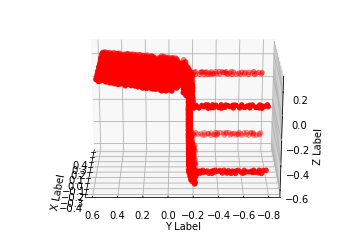

In [13]:
import random
#idx4pred=random.randint(0,len(pred))
print(idx4pred)
print("the actual class is :{} , the predicted class is {}".format(d['classes'][np.argmax(Y_test[idx4pred])], d['classes'][np.argmax(pred[idx4pred])]))

plot_ply(test_points_r[idx4pred])

the actual class is :desk , the predicted class is desk


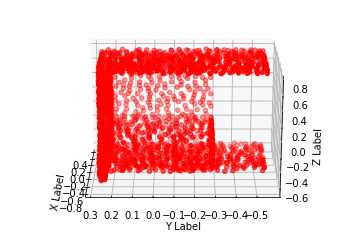

In [21]:
idx4pred=y_test_ls.index('desk') 
print("the actual class is :{} , the predicted class is {}".format(d['classes'][np.argmax(Y_test[idx4pred])], d['classes'][np.argmax(pred[idx4pred])]))

plot_ply(test_points_r[idx4pred])

the actual class is :monitor , the predicted class is monitor


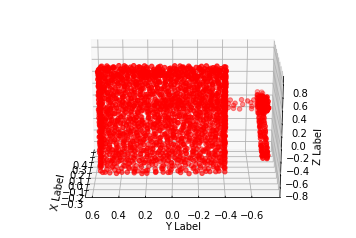

In [20]:
idx4pred=y_test_ls.index('monitor') 
print("the actual class is :{} , the predicted class is {}".format(d['classes'][np.argmax(Y_test[idx4pred])], d['classes'][np.argmax(pred[idx4pred])]))

plot_ply(test_points_r[idx4pred])

the actual class is :toilet , the predicted class is toilet


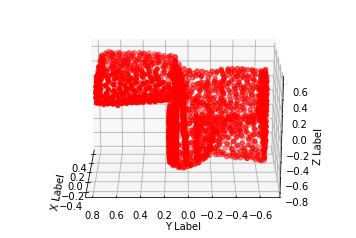

In [22]:
idx4pred=y_test_ls.index('toilet') 
print("the actual class is :{} , the predicted class is {}".format(d['classes'][np.argmax(Y_test[idx4pred])], d['classes'][np.argmax(pred[idx4pred])]))

plot_ply(test_points_r[idx4pred])